# Batch 3 - Developing Daily Load Profiles

## Install required libraries

In [1]:
!pip install sktime
!pip install pyspark

## Import required libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, date_format, min, max, hour, avg
import matplotlib.pyplot as plt

## Import data

In [4]:
spark = SparkSession.builder.appName("TimeSeriesBatchProcessing").getOrCreate()

In [5]:
data = '/content/drive/My Drive/Power_flow_data/2010-07-02.csv'

In [6]:
df = spark.read.csv(data, header=True)

## Quick EDA

### Data understanding

In [7]:
min_interval = 5
time_in_minutes = (df.select('Timestamp').distinct().count()) * 5
hours = time_in_minutes // 60
minutes = time_in_minutes % 60
min_timestamp = df.agg(min(date_format("Timestamp", "HH:mm:ss"))).collect()[0][0]
max_timestamp = df.agg(max(date_format("Timestamp", "HH:mm:ss"))).collect()[0][0]

print("Number of rows = ", str(df.count()))
print("Number of power lines = ", str(df.select('PowerLineID').distinct().count()))
print("Time measured = ",str(hours) + " hours and ", str(minutes), " minutes")
print("Min time = ", str(min_timestamp))
print("Max time = ", str(max_timestamp))

df.show()

Number of rows =  551808
Number of power lines =  1916
Time measured =  24 hours and  0  minutes
Min time =  00:00:00
Max time =  23:55:00
+-------------------+---------+-----------+--------------+
|          Timestamp|DayOfWeek|PowerLineID|PowerFlowValue|
+-------------------+---------+-----------+--------------+
|2010-07-02 00:00:00|   Friday|       1215|        -150.0|
|2010-07-02 00:00:00|   Friday|        182|           0.0|
|2010-07-02 00:00:00|   Friday|        577|           0.0|
|2010-07-02 00:00:00|   Friday|       1456|       -125.53|
|2010-07-02 00:00:00|   Friday|       1405|         81.66|
|2010-07-02 00:00:00|   Friday|       1780|         10.97|
|2010-07-02 00:00:00|   Friday|       1182|           0.0|
|2010-07-02 00:00:00|   Friday|        186|           0.0|
|2010-07-02 00:00:00|   Friday|       1749|           0.0|
|2010-07-02 00:00:00|   Friday|       1390|        -26.02|
|2010-07-02 00:00:00|   Friday|        163|       -328.53|
|2010-07-02 00:00:00|   Friday|    

### Average power flow values per hour for a sample powerline.

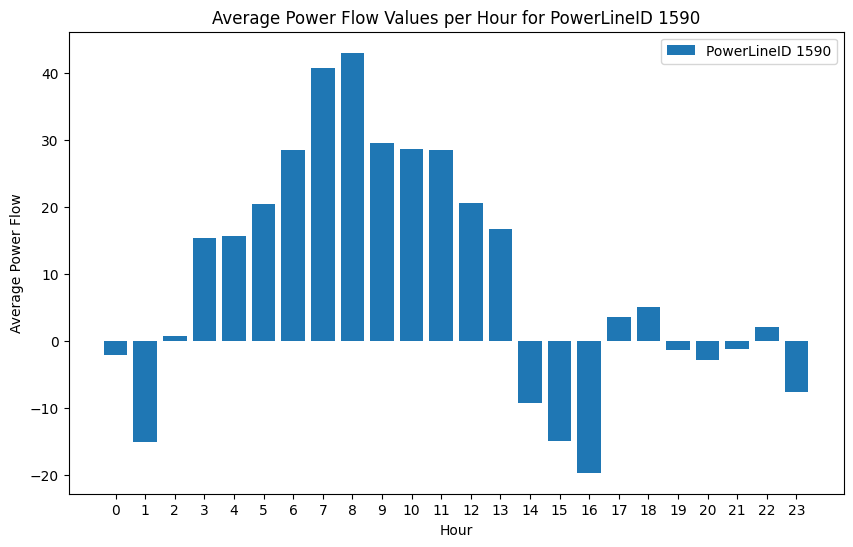

In [8]:
powerline_id = "1590"
filtered_df = df.filter(col("PowerLineID") == powerline_id)

# Group by hour and calculate the average power flow value for each hour
hourly_avg_df = (
    filtered_df
    .withColumn("Hour", hour("Timestamp"))
    .groupBy("PowerLineID", "Hour")
    .agg(avg("PowerFlowValue").alias("AveragePowerFlow"))
)

# Extract Hour and AveragePowerFlow columns for plotting
hours = [row["Hour"] for row in hourly_avg_df.select("Hour").collect()]
average_power_flow_values = [row["AveragePowerFlow"] for row in hourly_avg_df.select("AveragePowerFlow").collect()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(hours, average_power_flow_values, label=f"PowerLineID {powerline_id}")
plt.title(f"Average Power Flow Values per Hour for PowerLineID {powerline_id}")
plt.xlabel("Hour")
plt.ylabel("Average Power Flow")
plt.xticks(hours)
plt.legend()
plt.show()

### Hourly average power flow for each powerline

In [9]:
hourly_avg_df = (
    df
    .withColumn("Hour", hour("Timestamp"))
    .groupBy("PowerLineID", "Hour")
    .agg(avg("PowerFlowValue").alias("AveragePowerFlow"))
)

print("Number of rows = ", str(hourly_avg_df.count()))
hourly_avg_df.show()

Number of rows =  45984
+-----------+----+-------------------+
|PowerLineID|Hour|   AveragePowerFlow|
+-----------+----+-------------------+
|         19|   0| 1186.2916666666665|
|         73|   0| -225.1833333333333|
|       1412|   0|-1.3741666666666683|
|        754|   0|  32.04833333333334|
|        771|   0|  77.46083333333333|
|        450|   0|           -62.1525|
|        860|   0| -4.081666666666667|
|        884|   0|          -127.5225|
|        542|   0|            10.7275|
|       1888|   0| 42.116666666666674|
|        394|   0| -413.8858333333333|
|       1747|   1|                0.0|
|        419|   1|             -29.95|
|         69|   1|  85.44749999999999|
|        787|   1|                0.0|
|         37|   1|-235.89083333333335|
|        409|   1| 161.68499999999997|
|       1143|   1|                0.0|
|       1363|   1|                0.0|
|       1594|   1|-108.15499999999997|
+-----------+----+-------------------+
only showing top 20 rows



### Daily average power flow for each power line

In [10]:
daily_avg_df = (
    df
    .groupBy("PowerLineID", "DayOfWeek")
    .agg(avg("PowerFlowValue").alias("AveragePowerFlow"))
)

print("Number of rows = ", str(daily_avg_df.count()))
daily_avg_df.show()

Number of rows =  1916
+-----------+---------+-------------------+
|PowerLineID|DayOfWeek|   AveragePowerFlow|
+-----------+---------+-------------------+
|         48|   Friday|                0.0|
|       1754|   Friday|                0.0|
|         41|   Friday|-214.75362848229167|
|        655|   Friday| 222.92850690972216|
|       1878|   Friday| 113.08234374999999|
|       1894|   Friday|                0.0|
|        196|   Friday| -161.6577777777778|
|        569|   Friday|  88.56590274305553|
|        949|   Friday|-124.02562497916662|
|       1077|   Friday| -69.71883679166667|
|        213|   Friday|-250.33439236111104|
|        997|   Friday| -63.26743055381942|
|        494|   Friday|  16.25034722812501|
|        571|   Friday| 48.351788197916655|
|       1738|   Friday|                0.0|
|        555|   Friday| 109.14008680972222|
|        961|   Friday|-112.81227430555558|
|        814|   Friday| -97.40086804166668|
|       1813|   Friday|-20.900538197916667|
|        

### Overall daily average power flow

In [11]:
overall_daily_avg_df = (
    df
    .groupBy("DayOfWeek")
    .agg(avg("PowerFlowValue").alias("OverallDailyAveragePowerFlow"))
)

overall_daily_avg_df.show()

+---------+----------------------------+
|DayOfWeek|OverallDailyAveragePowerFlow|
+---------+----------------------------+
|   Friday|          3.7456207412587483|
+---------+----------------------------+



In [12]:
### Next steps: profiling each training datasets and then creating a forecasting model!

In [13]:
# @title Training CSV Files
# List of file paths for different days
train = ['/content/drive/My Drive/Power_flow_data/2010-07-01.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-02.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-03.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-04.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-05.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-06.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-07.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-08.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-09.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-10.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-11.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-12.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-13.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-14.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-15.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-16.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-17.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-18.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-19.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-20.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-21.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-22.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-23.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-24.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-25.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-26.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-27.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-28.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-29.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-30.csv',
              '/content/drive/My Drive/Power_flow_data/2010-07-31.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-01.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-02.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-03.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-04.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-05.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-06.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-07.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-08.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-09.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-10.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-11.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-12.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-13.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-14.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-15.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-16.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-17.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-18.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-19.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-20.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-21.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-22.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-23.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-24.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-25.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-26.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-27.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-28.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-29.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-30.csv',
              '/content/drive/My Drive/Power_flow_data/2010-08-31.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-01.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-02.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-03.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-04.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-05.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-06.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-07.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-08.csv'
             ]

test = ['/content/drive/My Drive/Power_flow_data/2010-09-09.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-10.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-11.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-12.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-13.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-14.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-15.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-16.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-17.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-18.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-19.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-20.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-21.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-22.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-23.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-24.csv',
              '/content/drive/My Drive/Power_flow_data/2010-09-25.csv'
              ]